In [30]:
import sys
sys.path.append('lib/src/')
import torch
from torch import nn
import os
import numpy as np
from matplotlib import pyplot as plt

from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler
from lib.src.pythae.trainers.training_callbacks import WandbCallback

from geometric_perspective_on_vaes.sampling import build_metrics, hmc_sampling

%reload_ext autoreload
%autoreload 2

In [2]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
train_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'))[:-1000, :-1, :, :, :].to(device) #removing the last obs which is the same as the first
eval_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_train.pt'), map_location="cpu")[-1000:, :-1, :, :, :].to(device)
#test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, -1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3).reshape(-1, 3, 64, 64)
eval_data = eval_data.permute(0, 1, 4, 2, 3).reshape(-1, 3, 64, 64)
#test_data = test_data.permute(0, 3, 1, 2)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool).to(device)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool).to(device)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

torch.Size([8000, 7, 64, 64, 3])
torch.Size([56000, 3, 64, 64])


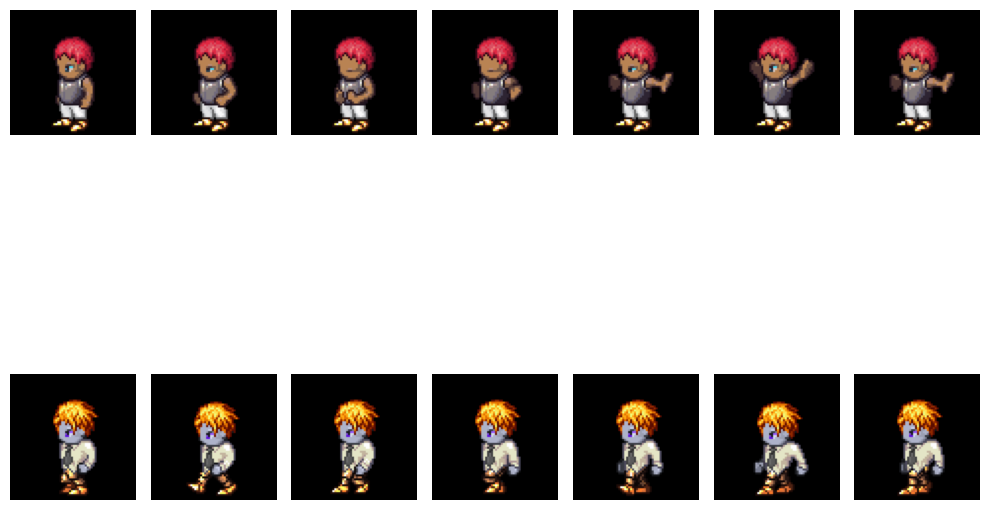

In [5]:
#check

plt.figure(figsize=(10, 10))
for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(train_dataset[i][0].data.cpu().permute(1, 2, 0))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [3]:
input_dim = (3, 64, 64)
f = 32 #subsampling factor
new_num_channels = 3
latent_dim = new_num_channels* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

training_config = BaseTrainerConfig(output_dir='pre-trained_vae',
num_epochs=100,
learning_rate=1e-3,
per_device_train_batch_size=200,
per_device_eval_batch_size=200,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=50,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 3, "factor": 0.8})


Latent dim: 12


In [4]:
model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
encoder = Encoder_Chairs(model_config)
decoder = Decoder_Chairs(model_config)
device = 'cpu'
print(device)

#vae = VAE(model_config=model_config, encoder=encoder, decoder=decoder).to(device)
vae = VAE.load_from_folder('pre-trained_vae/VAE_training_2024-06-16_15-12-03/final_model').to(device)


x = train_dataset[0:100]
print(x.data.shape)
x.data = x.data.unsqueeze(0).to(device)
print(x.data.shape)

out = vae(x)
out['recon_x'].shape

cpu
torch.Size([100, 3, 64, 64])
torch.Size([1, 100, 3, 64, 64])


torch.Size([1, 100, 3, 64, 64])

In [5]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name="pre_training_VAE_latdim8_fulldataset", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: meilame-tayebjee. Use `wandb login --relogin` to force relogin


In [ ]:
vae = vae.to('cuda')
pipeline = TrainingPipeline(
    training_config=training_config,
    model=vae
)
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset,
    callbacks=callbacks
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


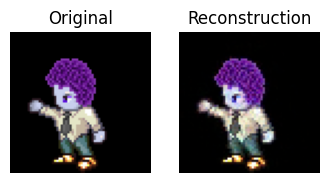

In [7]:
idx = 10000
x = train_dataset[idx]
vae = vae.to('cpu')
out = vae(x)

plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(x.data.cpu().permute(1, 2, 0))
plt.title('Original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(out['recon_x'].data.cpu().permute(1, 2, 0))
plt.title('Reconstruction')
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

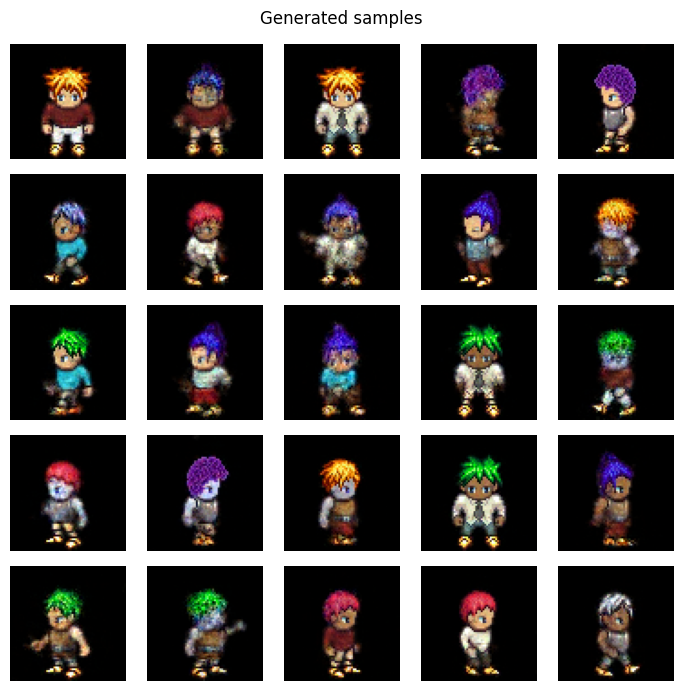

In [16]:
normal_sampler = NormalSampler(
    model=vae
)
gen_data = normal_sampler.sample(
    num_samples=25
)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(7, 7))
plt.suptitle('Generated samples')
for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5+j].cpu().permute(1, 2, 0))
        axes[i][j].axis('off')
plt.tight_layout()
plt.show()

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True)
device = 'cuda'
vae = vae.to(device)

mu = []
log_var = []
with torch.no_grad():
    for _ , x in enumerate(train_loader):

        data = x.data

        out = vae.encoder(data.to(device))

        mu_data, log_var_data = out.embedding, out.log_covariance

        mu.append(mu_data)
        log_var.append(log_var_data)

mu = torch.cat(mu)
log_var = torch.cat(log_var)

In [13]:
print('Running Kmedoids')
print(device)
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=500).fit(mu.detach().cpu())
print('done')
medoids = torch.tensor(kmedoids.cluster_centers_).to(device)
centroids_idx = kmedoids.medoid_indices_ #

Running Kmedoids
cuda


/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 41 is empty! self.labels_[self.medoid_indices_[41]] may not be labeled with its corresponding cluster (41).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 62 is empty! self.labels_[self.medoid_indices_[62]] may not be labeled with its corresponding cluster (62).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 75 is empty! self.labels_[self.medoid_indices_[75]] may not be labeled with its corresponding cluster (75).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 97 is empty! self.labels_[self.medoid_indices_[97]] may not be la

done


In [24]:
print("Finding temperature")
eps_lf = 0.1
lbd = 0.01
T = 0
T_is = []
for i in range(len(medoids)-1):
    mask = torch.tensor([k for k in range(len(medoids)) if k != i])
    dist = torch.norm(medoids[i].unsqueeze(0) - medoids[mask], dim=-1)
    T_i =torch.min(dist, dim=0)[0]
    T_is.append(T_i.item())

T = np.max(T_is)
print('Best temperature found: ', T)

print('Building metric')
vae = build_metrics(vae, mu, log_var, centroids_idx, T=T*1.5, lbd=lbd)

Finding temperature
Best temperature found:  2.27055313060455
Building metric


In [25]:
n_samples = 1000
batch_size = 1000

all_z = []

device = 'cuda'
vae = vae.to(device)
mu = mu.to(device)

for j in range(0, int(n_samples / batch_size)):
    z, p = hmc_sampling(vae, mu, n_samples=batch_size, mcmc_steps_nbr=100)
    all_z.append(z)

p = p[0]

omega
tensor([[[[8.4413e-20]],

         [[4.7138e-12]],

         [[1.3889e-18]],

         ...,

         [[5.3169e-23]],

         [[4.5727e-19]],

         [[7.7568e-22]]],


        [[[3.8734e-16]],

         [[5.4088e-17]],

         [[1.6595e-12]],

         ...,

         [[2.5825e-10]],

         [[1.5642e-06]],

         [[4.1840e-06]]],


        [[[1.5249e-17]],

         [[7.7107e-30]],

         [[5.5468e-12]],

         ...,

         [[3.0831e-19]],

         [[8.0766e-15]],

         [[8.6657e-15]]],


        ...,


        [[[9.0335e-11]],

         [[7.4653e-13]],

         [[2.9005e-10]],

         ...,

         [[7.8694e-15]],

         [[9.6884e-10]],

         [[2.0490e-08]]],


        [[[1.5926e-09]],

         [[5.8568e-14]],

         [[2.3337e-15]],

         ...,

         [[2.3441e-11]],

         [[2.3279e-16]],

         [[1.5169e-16]]],


        [[[1.3496e-10]],

         [[4.1989e-14]],

         [[7.1196e-15]],

         ...,

         [[6.0420e-09

In [19]:
z = vae.encoder(train_dataset[25000][0].data.unsqueeze(0).to(device)).embedding
vae.G_sampl(z)

omega
tensor([[[[5.3497e-13]],

         [[1.6806e-09]],

         [[1.4809e-13]],

         [[1.1188e-08]],

         [[2.8100e-09]],

         [[1.0427e-15]],

         [[2.3395e-14]],

         [[1.4162e-15]],

         [[6.7005e-07]],

         [[3.1083e-12]],

         [[7.1907e-10]],

         [[1.0317e-08]],

         [[9.2450e-13]],

         [[7.4264e-12]],

         [[2.8895e-11]],

         [[1.6322e-12]],

         [[2.7523e-14]],

         [[2.0298e-14]],

         [[1.7830e-09]],

         [[1.6127e-11]],

         [[2.2227e-07]],

         [[2.6920e-11]],

         [[4.1627e-10]],

         [[3.3491e-13]],

         [[8.0438e-11]],

         [[7.3603e-11]],

         [[3.8039e-12]],

         [[5.6203e-13]],

         [[1.2789e-10]],

         [[4.3994e-13]],

         [[1.0876e-07]],

         [[2.8679e-10]],

         [[6.5447e-12]],

         [[1.0123e-16]],

         [[5.9596e-13]],

         [[2.5378e-13]],

         [[1.9114e-08]],

         [[2.7465e-11]],

      

tensor([[[0.0276, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0121, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0112, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0329, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0472, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0675, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0221, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0507,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [26]:
all_z = torch.cat(all_z, dim=0)
all_z.shape

torch.Size([1000, 12])

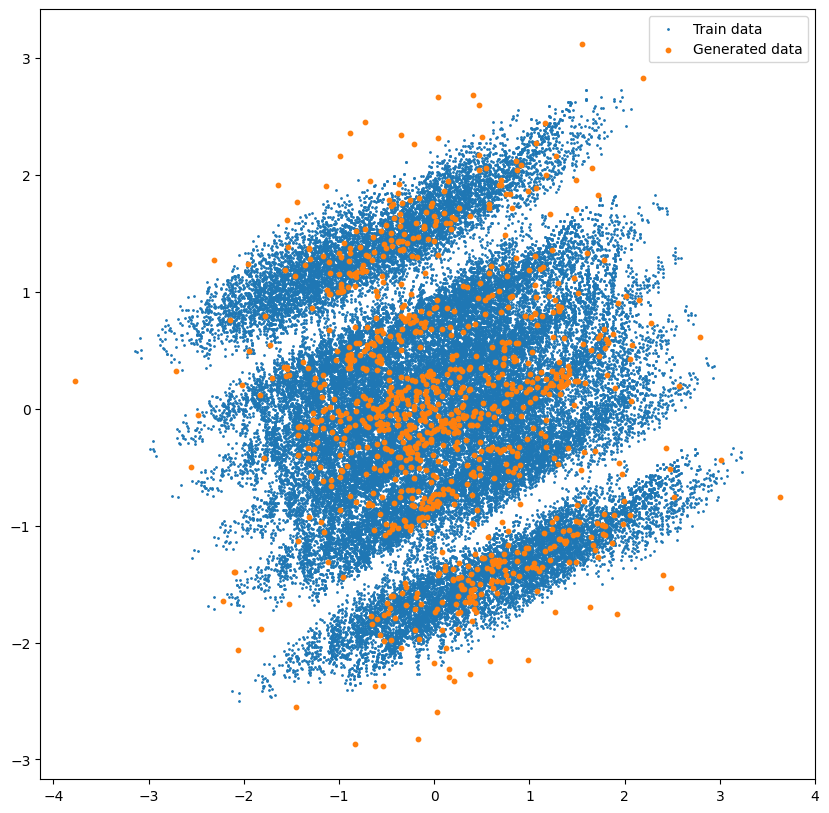

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding
train_pca = pca.fit_transform(train_embeddings.detach().numpy())

all_z_pca = pca.transform(all_z.cpu().detach().numpy())
p_pca  = pca.transform(p.cpu().detach().numpy())

plt.figure(figsize=(10, 10))
plt.scatter(train_pca[:, 0], train_pca[:, 1], label='Train data', s= 1)
plt.scatter(all_z_pca[:, 0], all_z_pca[:, 1], s = 10, label='Generated data')
#plt.scatter(p_pca[:, 0], p_pca[:, 1], s = 10, label='Path')
plt.legend()
plt.show()

In [28]:
torch.save(all_z, 'zT_samples.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

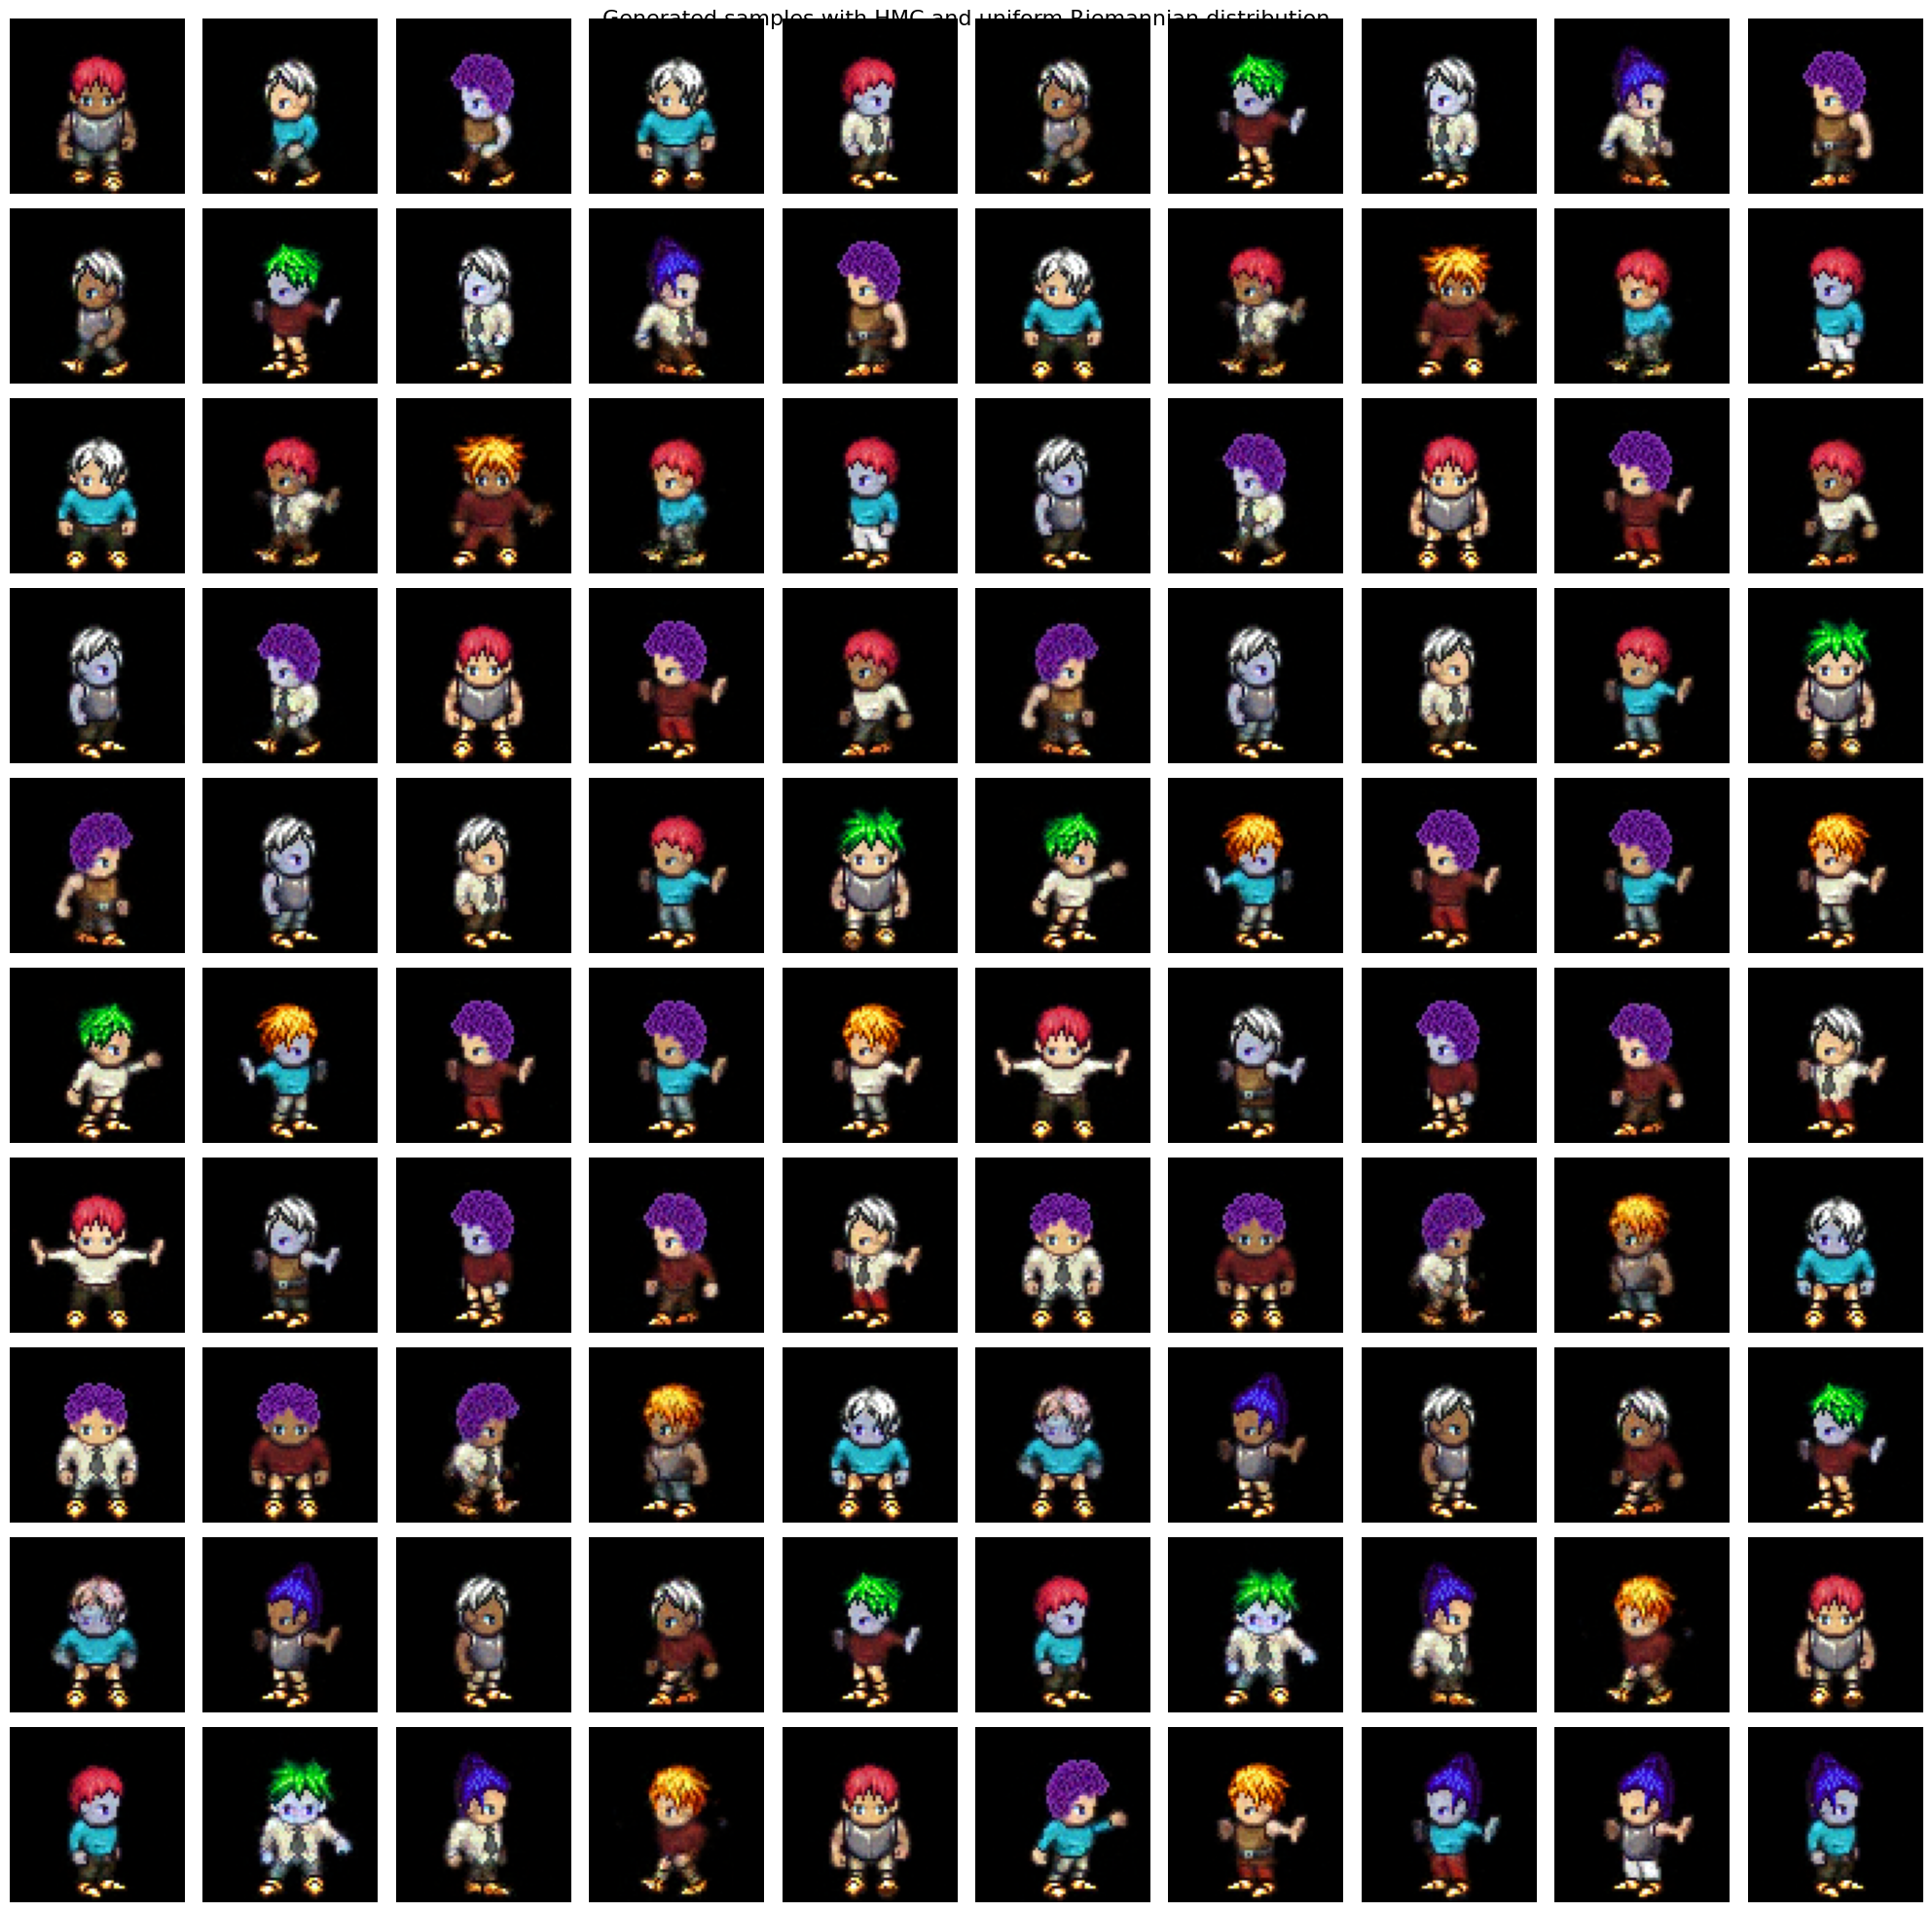

In [29]:
vae = vae.to('cpu')
all_z= all_z.to('cpu').detach()

gen_data = vae.decoder(all_z).reconstruction.detach()

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axes[i][j].imshow(gen_data[i*5+j].permute(1, 2, 0))
        axes[i][j].axis('off')

fig.suptitle('Generated samples with HMC and uniform Riemannian distribution', fontsize=16)
plt.tight_layout()
plt.show()